# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para Epilepsy a ser clasificado con las series en bruto sobre LSTM

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'HeartBeat_tmp_test_data.pkl',
 'HeartBeat_tmp_train_data.pkl',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
EPILEPSY_PATH = "data/epilepsy"

DATA_TO_SAVE = "Epilepsy"

PKL_DIR = "pkl/LSTM/Epilepsy/"
PKL_NAME = "epilepsy_LSTM_raw.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_epilepsy_dataset

train, test = import_epilepsy_dataset(EPILEPSY_PATH)

In [4]:
train.reset_changes()
test.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- Eliminaremos aquellos valores fuera de los percentiles 5 y 95.
- El grado de outliers mínimo en, al menos, una dimensión para eliminar una serie temporal será del 80% (si más del 80% de los datos son anómalos descartamos la serie).
  - A pesar de que esto pueda parecer muy grande debemos comprender que, la probabilidad con la que aparezca ruido en una de las dimensiones de una serie temporal multivariada, es muy alta (tenemos varias series temporales con ruido cada una).

In [5]:
train.remove_outliers(
    headers=train.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)

test.remove_outliers(
    headers=test.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)


In [6]:
import pandas as pd

# Remaining series
print("Train: Previous number of series: {}".format(
    len(pd.unique(train.original_data['id']))))
print("Train: Actual number of series: {}".format(
    len(pd.unique(train.derived_data['id']))))

print("Test: Previous number of series: {}".format(
    len(pd.unique(test.original_data['id']))))
print("Test: Actual number of series: {}".format(
    len(pd.unique(test.derived_data['id']))))


Train: Previous number of series: 137
Train: Actual number of series: 137
Test: Previous number of series: 138
Test: Actual number of series: 138


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como concluimos en el análisis en profundidad, mantendremos la resolución original.

In [7]:
# Nothing to see here

# <font color=#cd0000> Codificación </font>
- Series en bruto

In [8]:
# Nothing to see here

## <font color=#cd0000> Normalización </font>

In [9]:
from utils.codifications import standardize_data

train.derived_data, test.derived_data = standardize_data(
    train.derived_data,
    test.derived_data,
    headers=train.get_derived_data_columns()['attrs']
)


## <font color=#cd0000> Tensores entrada y salida de la red </font>

In [10]:
# All lengths must be equal
series_length = train.get_shortest_serie().shape[0]
n_dims = len(train.get_derived_data_columns()['attrs'])

(
    train.get_shortest_serie().shape[0],
    train.get_largest_serie().shape[0],
    test.get_shortest_serie().shape[0],
    test.get_largest_serie().shape[0]
)


(206, 206, 206, 206)

In [11]:
import pandas as pd

# This will determine the number of series of each split
train_n_series = pd.unique(train.derived_data['id']).shape[0]
test_n_series = pd.unique(test.derived_data['id']).shape[0]

(train_n_series, test_n_series)


(137, 138)

In [12]:
X_train, _ = train.transform_derived_data_into_X_y()
X_test, _ = test.transform_derived_data_into_X_y()

y_train = train.derived_data.groupby('id').first()['class'].to_numpy()
y_test = test.derived_data.groupby('id').first()['class'].to_numpy()


## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [13]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1],
                 2: class_weights[2], 3: class_weights[3]}


In [14]:
from utils.classifier_utils import apply_lstm_format
from sklearn.preprocessing import OneHotEncoder

sequences_fragmenter = 1

enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))

X_train, y_train = apply_lstm_format(
    X_train, y_train.reshape(-1, 1), train_n_series, series_length, sequences_fragmenter, enc)
X_test, y_test = apply_lstm_format(
    X_test, y_test.reshape(-1, 1), test_n_series, series_length, sequences_fragmenter, enc)


# <font color=#cd0000> Diseño de la topología de red </font>

## <font color=#cd0000> Preparación de mecanismo argmax en caso de salida multiclase </font>

In [15]:
import numpy as np
import keras.backend as K


def argmax(x, n_classes):
    all_predictions = []
    for max_class_position in K.argmax(x):
        prediction = np.zeros(n_classes)
        prediction.put(max_class_position, 1)
        all_predictions.append(prediction)
    return np.asarray(all_predictions)


In [16]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense

nn = Sequential()

# Number of initial dimensions
nn.add(LSTM(units=12, return_sequences=True, dropout=.2, recurrent_dropout=.2))
nn.add(LSTM(units=6, dropout=.2, recurrent_dropout=.2))
# Number of Epilepsy's classes
nn.add(Dense(4, activation='softmax'))


## <font color=#cd0000> Compilación de la red </font>

In [17]:
from keras.optimizers import RMSprop

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]

nn.compile(optimizer=RMSprop(
    learning_rate=5e-3), loss='categorical_crossentropy', metrics=metrics)


## <font color=#cd0000> Visualización de resultados preliminares </font>

In [18]:
import matplotlib.pyplot as plt


def show_metrics(history):
    for metric in history.history.keys():
        if not metric.startswith('val_'):
            plt.plot(history.history[metric], label=metric)
            plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
            plt.title(metric)
            plt.ylabel('')
            plt.xlabel('Epoch')
            plt.legend(loc="upper left")
            plt.show()


## <font color=#cd0000> Entrenamiento del modelo </font>

In [ ]:
import numpy as np
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

epochs = 100

history = nn.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test),
                 class_weight=class_weights,
                 verbose=1)
nn.summary()
print('\n\n')

y_pred = argmax(nn.predict(X_test), 4)

show_metrics(history)

## <font color=#cd0000> Clasificación </font>

In [ ]:
y_real = enc.inverse_transform(y_test)
y_pred = enc.inverse_transform(y_pred)
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

## <font color=#cd0000> Discusión de los resultados </font>
- Dimensionalidad de entrada inicial -> 3 atributos
- Vamos a estudiar diferentes rangos de hiper-parámetros que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para una red profunda de 2 capas dada la complejidad de las series (son rápidas):
   - Para un `n_units_capa1` de 2 veces la dim_entrada (6), `n_units_capa2` de 3 y un `learning_rate` rápido (1e-2) obtenemos resultados notablemente buenos para no estar utilizando ninguna codificación de entrada. En la evolución del error observamos sobreajuste de modo que aplicaremos una tasa de Dropout del 0.2 en ambas capas:
   ```
   Confusion matrix:
   [[25  5  3  1]
    [13 20  0  4]
    [ 2  0 27  1]
    [ 4  3  0 30]]

   Classification report:
                   precision    recall  f1-score   support

       epilepsy       0.57      0.74      0.64        34
        running       0.71      0.54      0.62        37
         sawing       0.90      0.90      0.90        30
        walking       0.83      0.81      0.82        37

       accuracy                           0.74       138
      macro avg       0.75      0.75      0.74       138
   weighted avg       0.75      0.74      0.74       138
   ```

   - Para un `n_units` de 2 veces la dim_entrada (6), `n_units_capa2` de 3 y un `learning_rate` rápido (1e-2) con una tasa de Dropout de 0.2 en ambas capas observamos que los resultados empeoran notablemente y esto se debea que el aprendizaje es más lento y la red penaliza la complejidad del modelo que era nuestra base para ajustar bien las series, probemos a disminuir la tasa de aprendizaje:
   ```
   Confusion matrix:
   [[18  7  7  2]
    [ 8 29  0  0]
    [15  0 14  1]
    [ 5  2  0 30]]

   Classification report:
                   precision    recall  f1-score   support

       epilepsy       0.39      0.53      0.45        34
        running       0.76      0.78      0.77        37
         sawing       0.67      0.47      0.55        30
        walking       0.91      0.81      0.86        37

       accuracy                           0.66       138
      macro avg       0.68      0.65      0.66       138
   weighted avg       0.69      0.66      0.67       138
   ```

   - Para un `n_units` de 2 veces la dim_entrada (6), `n_units_capa2` de 3 y un `learning_rate` lento (1e-5) y tasa de Dropout de 0.2 y observamos que la tasa de aprendizaje es tan pequeña que la red queda atrapada en un mínimo local:
   ```
   Confusion matrix:
   [[ 5  4 22  3]
    [ 6 13 18  0]
    [ 1  0 28  1]
    [ 5 22 10  0]]

   Classification report:
                   precision    recall  f1-score   support

       epilepsy       0.29      0.15      0.20        34
        running       0.33      0.35      0.34        37
         sawing       0.36      0.93      0.52        30
        walking       0.00      0.00      0.00        37

       accuracy                           0.33       138
      macro avg       0.25      0.36      0.26       138
   weighted avg       0.24      0.33      0.25       138
   ```
   - Para un `n_units` de 2 veces la dim_entrada (6), `n_units_capa2` de 3 y un `learning_rate` intermedio (5e-3) y tasa de Dropout de 0.2 y observamos unos resultados algo mejores, probaremos a incrementar la complejidadde la red añadiendo el doble de neuronas a cada capa para aprender más rápido:
   ```
   Confusion matrix:
     [[24 10  0  0]
      [ 2 32  0  3]
      [27  0  3  0]
      [ 3  3  0 31]]

   Classification report:
                 precision    recall  f1-score   support

      epilepsy       0.43      0.71      0.53        34
       running       0.71      0.86      0.78        37
        sawing       1.00      0.10      0.18        30
       walking       0.91      0.84      0.87        37

      accuracy                           0.65       138
     macro avg       0.76      0.63      0.59       138
   eighted avg       0.76      0.65      0.61       138
   ```

   - Para un `n_units` de 4 veces la dim_entrada (12), `n_units_capa2` de 6 y un `learning_rate` intermedio (5e-3) y una tasa de Dropout de 0.2 obtenemos unos resultados bastante mejores en todos los sentidos, no obstantese sigue visualizando un ligero sobreajuste:
   ```
   Confusion matrix:
   [[29  1  1  3]
    [ 7 30  0  0]
    [11  0 19  0]
    [ 3  4  0 30]]

   Classification report:
                  precision    recall  f1-score   support

      epilepsy       0.58      0.85      0.69        34
       running       0.86      0.81      0.83        37
        sawing       0.95      0.63      0.76        30
       walking       0.91      0.81      0.86        37

      accuracy                           0.78       138
     macro avg       0.82      0.78      0.79       138
   eighted avg       0.82      0.78      0.79       138
   ``
- Probemos ahora a aumentar la complejidad de la red en una capa más partiendo de la hipótesis que, para series complejas, redes complejas que eviten el sobreajuste:
  - Para un `n_units` de 4 veces la dim_entrada (12), `n_units_capa2` de 6, `n_units_capa3` de 3 y un `learning_rate` intermedio (5e-3) y observamos un sobreajuste importante ante la profundidad del modelo por lo que la mantendermos como estaba:
  ```
  Confusion matrix:
  [[ 7 17 10  0]
   [16 18  0  3]
   [ 0  0 30  0]
   [ 3  9  0 25]]

  Classification report:
                  precision    recall  f1-score   support

      epilepsy       0.27      0.21      0.23        34
       running       0.41      0.49      0.44        37
        sawing       0.75      1.00      0.86        30
       walking       0.89      0.68      0.77        37

      accuracy                           0.58       138
     macro avg       0.58      0.59      0.58       138
  weighted avg       0.58      0.58      0.57       138
  ```
  


## <font color=#cd0000> Conclusiones </font>
- Como podemos observar en los casos en que contemplamos la hipótesis de aplicar mayor complejidad a una red si la serie es muy compleja, el desempeño, mejora y esto es en gran parte porque la topología de la red influye singnificativamente sobre la clasificación y no me refiero a los hiper-parámetros (que también), sino, a como está dispuesta la propia red y cómo considera la complejidad de las series.
- Unos rangos orientativos de búsqueda serían:
  - `n_units_capa_1`: [3, 24]
  - `n_units_capa_2` fijo a 6
  - `learning_rate`: [1e-2, 5e-3]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con LSTM maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [19]:
N_UNITS_RANGE = range(3, 24)
LEARNING_RATE_CHOICES = [1e-2, 8e-3, 7e-3, 6e-3, 5e-3]

In [20]:
import random
import pickle
import utils.constants as cs
from utils.classifier_utils import (windowed_cross_val,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop


def lstm_randomized_search_cv(
        windowed_series,
        relation_with_series,
        prefix,
        cv=5,
        lstm_dict={}):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    units_list = random.sample(
        list(N_UNITS_RANGE), n_samples)
    learning_rate_list = random.sample(
        LEARNING_RATE_CHOICES, n_samples)

    best_hyp_params = None
    best_score = 0
    for units in units_list:
        for learning_rate in learning_rate_list:
            lstm_dict[cs.LSTM_HYP_PARAM_UNITS] = units
            lstm_dict[cs.LSTM_HYP_PARAM_LEARNING_RATE] = learning_rate
            reports = windowed_cross_val(
                None,
                windowed_series,
                relation_with_series,
                cv=cv,
                seed=SEED,
                drop_columns=['class'],
                estimator_type=cs.ESTIMATOR_LSTM,
                lstm_dict=lstm_dict
            )

            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(units, learning_rate)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (units, learning_rate)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: Units={}; Learning Rate={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: Units={}; Learning Rate={}--------------"
                  .format(units, learning_rate))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [21]:
# IMPORTANTE -> ALGUNOS DE LOS PARÁMETROS DEL MODELO SON FIJADOS EN EL MÉTODO lstm_build_model del módulo
# classifier_utils.py ante problemas a la hora de clonar modelos neuronales de Keras.

# Los parámetros fijados a fuego en el código son:
#   · Una segunda capa oculta con el nº de neuronas fijas a 6
#   · Las tasas de Dropout recurrentes y de la misma capa a 0.2

lstm_dict = {
    cs.LSTM_SERIES_LENGTH: series_length,
    cs.LSTM_SEQUENCES_FRAGMENTER: 1,
    cs.LSTM_FITTED_LABELS_ENCODER: enc,
    cs.LSTM_ARGMAX_FUNCTION: argmax,
    cs.LSTM_N_CLASSES: 4,
    cs.LSTM_CLASS_WEIGHTS: class_weights,
    cs.LSTM_HYP_PARAM_EPOCHS: 100
}

lstm_randomized_search_cv(
    train.derived_data,
    train.derived_data_windows_per_serie,
    PKL_NAME,
    cv=5,
    lstm_dict=lstm_dict
)


		--------------ACTUAL BEST: Units=6; Learning Rate=0.007--------------
Accuracy: 0.710344827586207 +/- 0.30256223010726235
epilepsy:
	precision: 0.8 +/- 0.4000000000000001
	recall: 0.8 +/- 0.4000000000000001
	f1-score: 0.8 +/- 0.4000000000000001
	support: 6.8 +/- 1.6
running:
	precision: 0.5314285714285714 +/- 0.4387738016103421
	recall: 0.5314285714285714 +/- 0.4387738016103421
	f1-score: 0.526984126984127 +/- 0.4304368573124646
	support: 7.2 +/- 1.16619037896906
sawing:
	precision: 0.6834656084656084 +/- 0.3388174259351988
	recall: 0.9666666666666668 +/- 0.06666666666666665
	f1-score: 0.7380244755244755 +/- 0.264686065254684
	support: 6.0 +/- 0.6324555320336759
walking:
	precision: 0.7818181818181819 +/- 0.39249151172587093
	recall: 0.595 +/- 0.3822302970723279
	f1-score: 0.6495670995670996 +/- 0.36259152097505076
	support: 7.4 +/- 2.0591260281974
macro avg:
	precision: 0.6991780904280904 +/- 0.35477080954409734
	recall: 0.7232738095238094 +/- 0.26949580769060544
	f1-score: 0.678643

((11, 0.01),
 {'accuracy': (0.8040868454661558, 0.07513052949051513),
  'epilepsy': {'precision': (0.9305555555555556, 0.09043789220055391),
   'recall': (0.8642857142857142, 0.17554579610635013),
   'f1-score': (0.8785497835497835, 0.09067193349651768),
   'support': (6.8, 1.6)},
  'running': {'precision': (0.6676923076923076, 0.37439971678540845),
   'recall': (0.63, 0.38418745424597095),
   'f1-score': (0.6034920634920635, 0.32259404616219994),
   'support': (7.2, 1.16619037896906)},
  'sawing': {'precision': (0.8380952380952381, 0.18282241733764254),
   'recall': (0.8428571428571429, 0.2040408122440814),
   'f1-score': (0.7997668997668996, 0.11288503038794571),
   'support': (6.0, 0.6324555320336759)},
  'walking': {'precision': (0.8480158730158731, 0.11645050701705899),
   'recall': (0.86, 0.17435595774162696),
   'f1-score': (0.8321307706218193, 0.07741572814058473),
   'support': (7.4, 2.0591260281974)},
  'macro avg': {'precision': (0.8210897435897436, 0.12926627001726174),
   

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- En este caso ejecutaremos CV dado que tenemos suficientes series

In [ ]:
# Nothing to see here

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``n_units`` = 11 y ``learning_rate`` = 0.01:
    ```
        Accuracy: 0.8040868454661558 +/- 0.07513052949051513
        epilepsy:
            precision: 0.9305555555555556 +/- 0.09043789220055391
            recall: 0.8642857142857142 +/- 0.17554579610635013
            f1-score: 0.8785497835497835 +/- 0.09067193349651768
            support: 6.8 +/- 1.6
        running:
            precision: 0.6676923076923076 +/- 0.37439971678540845
            recall: 0.63 +/- 0.38418745424597095
            f1-score: 0.6034920634920635 +/- 0.32259404616219994
            support: 7.2 +/- 1.16619037896906
        sawing:
            precision: 0.8380952380952381 +/- 0.18282241733764254
            recall: 0.8428571428571429 +/- 0.2040408122440814
            f1-score: 0.7997668997668996 +/- 0.11288503038794571
            support: 6.0 +/- 0.6324555320336759
        walking:
            precision: 0.8480158730158731 +/- 0.11645050701705899
            recall: 0.86 +/- 0.17435595774162696
            f1-score: 0.8321307706218193 +/- 0.07741572814058473
            support: 7.4 +/- 2.0591260281974
        macro avg:
            precision: 0.8210897435897436 +/- 0.12926627001726174
            recall: 0.7992857142857144 +/- 0.07667017886069272
            f1-score: 0.7784848793576414 +/- 0.09501686799316901
            support: 27.4 +/- 0.8
        weighted avg:
            precision: 0.8129034021179615 +/- 0.13148497512985247
            recall: 0.8040868454661558 +/- 0.07513052949051513
            f1-score: 0.7794138954502401 +/- 0.10130075976035514
            support: 27.4 +/- 0.8
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [22]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


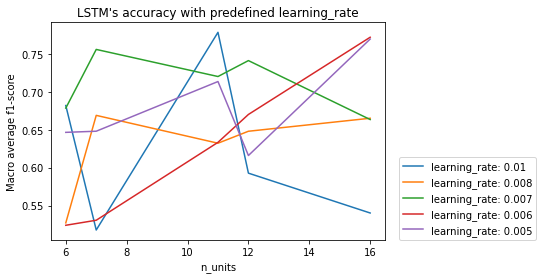

In [23]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


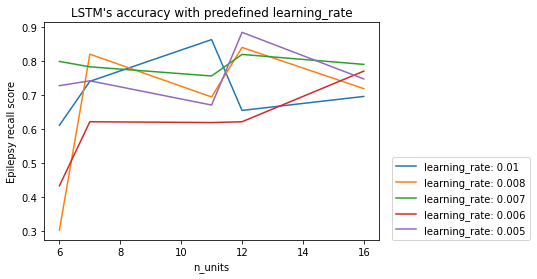

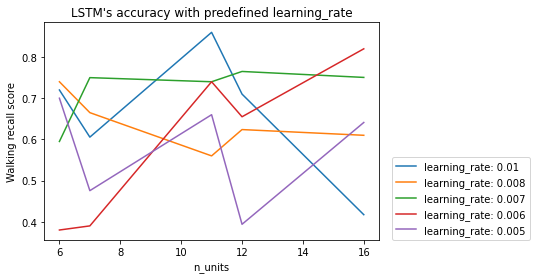

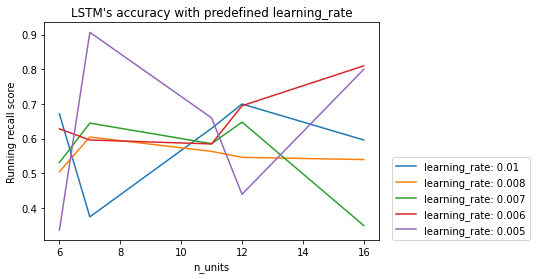

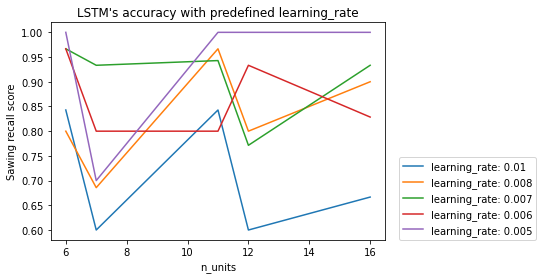

In [24]:
epilepsy_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['epilepsy']['recall'][0],
                   'std': all_reports[z]['epilepsy']['recall'][1]}),
    all_reports
))

walking_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['walking']['recall'][0],
                   'std': all_reports[z]['walking']['recall'][1]}),
    all_reports
))

running_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['running']['recall'][0],
                   'std': all_reports[z]['running']['recall'][1]}),
    all_reports
))

sawing_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['sawing']['recall'][0],
                   'std': all_reports[z]['sawing']['recall'][1]}),
    all_reports
))

plot_score(
    [epilepsy_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Epilepsy recall score'
)

plot_score(
    [walking_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Walking recall score'
)

plot_score(
    [running_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Running recall score'
)

plot_score(
    [sawing_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Sawing recall score'
)


## <font color=#cd0000> Evaluación sobre el conjunto de validación </font>
- Vamos a llevar a cabo la evaluación final sobre el conjunto de validación (esto es lo que irá al apartado de ``Pruebas y Resultados`` de la memoria).

### <font color=#cd0000> Construcción del modelo </font>

In [19]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense

nn = Sequential()

# Number of initial dimensions
nn.add(LSTM(units=11, dropout=.2, recurrent_dropout=.2, return_sequences=True))
nn.add(LSTM(units=6, dropout=.2, recurrent_dropout=.2))
# Number of Epilepsy's classes
nn.add(Dense(4, activation='softmax'))


In [20]:
from keras.optimizers import RMSprop

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]

nn.compile(optimizer=RMSprop(
    learning_rate=0.01), loss='categorical_crossentropy', metrics=metrics)


### <font color=#cd0000> Entrenamiento </font>

Epoch 1/100
5/5 [==============================] - 2s 333ms/step - loss: 1.3317 - ACC: 0.3358 - Prec: 0.0000e+00 - Rec: 0.0000e+00 - AUC: 0.6169 - val_loss: 1.2131 - val_ACC: 0.4783 - val_Prec: 0.0000e+00 - val_Rec: 0.0000e+00 - val_AUC: 0.7361
Epoch 2/100
5/5 [==============================] - 1s 171ms/step - loss: 1.1930 - ACC: 0.4745 - Prec: 0.7500 - Rec: 0.0219 - AUC: 0.7481 - val_loss: 1.1484 - val_ACC: 0.4783 - val_Prec: 1.0000 - val_Rec: 0.0217 - val_AUC: 0.7616
Epoch 3/100
5/5 [==============================] - 1s 168ms/step - loss: 1.1364 - ACC: 0.5109 - Prec: 0.7037 - Rec: 0.1387 - AUC: 0.7697 - val_loss: 1.1085 - val_ACC: 0.4928 - val_Prec: 0.6111 - val_Rec: 0.3986 - val_AUC: 0.7812
Epoch 4/100
5/5 [==============================] - 1s 164ms/step - loss: 1.0654 - ACC: 0.5474 - Prec: 0.6452 - Rec: 0.2920 - AUC: 0.8124 - val_loss: 1.0178 - val_ACC: 0.5725 - val_Prec: 0.7222 - val_Rec: 0.3768 - val_AUC: 0.8311
Epoch 5/100
5/5 [==============================] - 1s 166ms/step - l

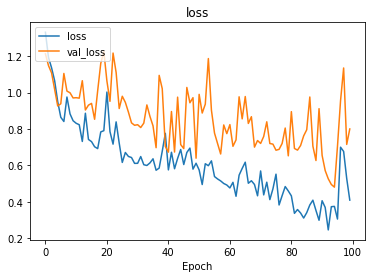

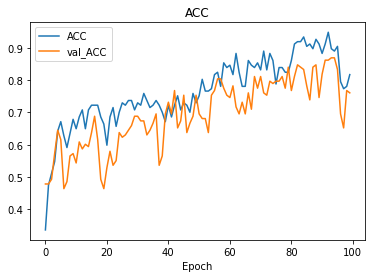

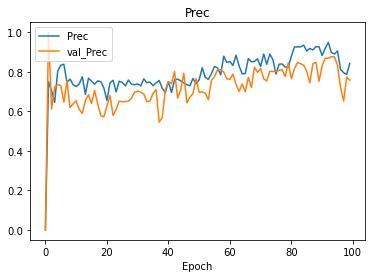

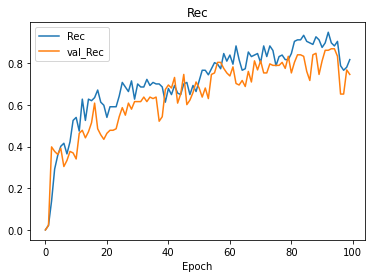

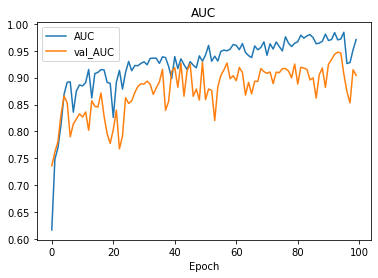

In [21]:
import numpy as np
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

epochs = 100

history = nn.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test))
nn.summary()
print('\n\n')

y_pred = argmax(nn.predict(X_test), 4)

show_metrics(history)

### <font color=#cd0000> Clasificación </font>

In [22]:
y_real = enc.inverse_transform(y_test)
y_pred = enc.inverse_transform(y_pred)
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

[[16 13  4  1]
 [ 0 34  1  2]
 [ 0  2 27  1]
 [ 3  5  1 28]]
              precision    recall  f1-score   support

    epilepsy       0.84      0.47      0.60        34
     running       0.63      0.92      0.75        37
      sawing       0.82      0.90      0.86        30
     walking       0.88      0.76      0.81        37

    accuracy                           0.76       138
   macro avg       0.79      0.76      0.75       138
weighted avg       0.79      0.76      0.75       138



# <font color=#cd0000> Conclusiones </font>
- En cuanto a los resultados observamos un mejor desempeño con respecto a RandomForest sobre las series en bruto tan solo teniendo en cuenta el orden secuencial de los datos.